# Kwok et al. (2020)

In [ ]:
%cd C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor

import xarray as xr
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer
import xesmf as xe
from cartopy import crs as ccrs
from cartopy import feature as cfeature

def load_kwok_snowdepth(filename):
    with h5py.File(filename, "r") as f:
        # Read ancillary metadata
        year = int(f["ancillary_data/data_year"][0])
        month = int(f["ancillary_data/data_month"][0])

        # Read grid info
        lat = f["grid/grid_latitude"][()]
        lon = f["grid/grid_longitude"][()]

        # Read main dataset
        snowdepth = f["monthly_grid/monthly_snowdepth"][()]
        snowdepth[snowdepth == -999.0] = np.nan  # Set fill values to NaN

    # Create coordinate arrays
    ny, nx = lat.shape
    snowdepth = snowdepth.reshape((1, ny, nx))
    # Build xarray Dataset
    ds = xr.Dataset(
        coords={
            "lat": (("y", "x"), lat),
            "lon": (("y", "x"), lon),
            "time": np.array([np.datetime64(f"{year:04d}-{month:02d}-15")])
        },
        data_vars={
            "sd": (("time","y", "x"), snowdepth)
        },
        attrs={
            "description": "Monthly mean snow depth",
            "source_file": filename
        }
    )
    return ds

def match_ASP_to_Kwok(ASP_ds, Kwok_ds):
    # Coarsen ASP data to approximately match Kwok resolution
    ASP_ds = ASP_ds.coarsen(x=8, y=8, boundary='trim').mean()

    # Transform ASP coordinates from EPSG:6931 to EPSG:4326
    transformer = Transformer.from_crs("epsg:6931", "epsg:4326", always_xy=True)
    X, Y = np.meshgrid(ASP_ds.x.values, ASP_ds.y.values)
    lon, lat = transformer.transform(X, Y)
    ASP_ds = ASP_ds.assign_coords(lon=(("y", "x"), lon), lat=(("y", "x"), lat))    

    # Create regridder
    regridder = xe.Regridder(ASP_ds, Kwok_ds, 'nearest_s2d', reuse_weights=False)
    
    # Regrid ASP data to Kwok grid
    ASP_regridded = regridder(ASP_ds)
    return ASP_regridded

kwok_files = [
    r"E:\ASP\Data\Kwok_snowDepths\snowdepth_201811_arctic.h5",
    r"E:\ASP\Data\Kwok_snowDepths\snowdepth_201812_arctic.h5",
    r"E:\ASP\Data\Kwok_snowDepths\snowdepth_201901_arctic.h5",
    r"E:\ASP\Data\Kwok_snowDepths\snowdepth_201902_arctic.h5",
    r"E:\ASP\Data\Kwok_snowDepths\snowdepth_201903_arctic.h5",
    r"E:\ASP\Data\Kwok_snowDepths\snowdepth_201904_arctic.h5"
]

ASP_files = [
    r".\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2018-11.nc",
    r".\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2018-12.nc",
    r".\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2019-01.nc",
    r".\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2019-02.nc",
    r".\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2019-03.nc",
    r".\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2019-04.nc"
    ]

C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor


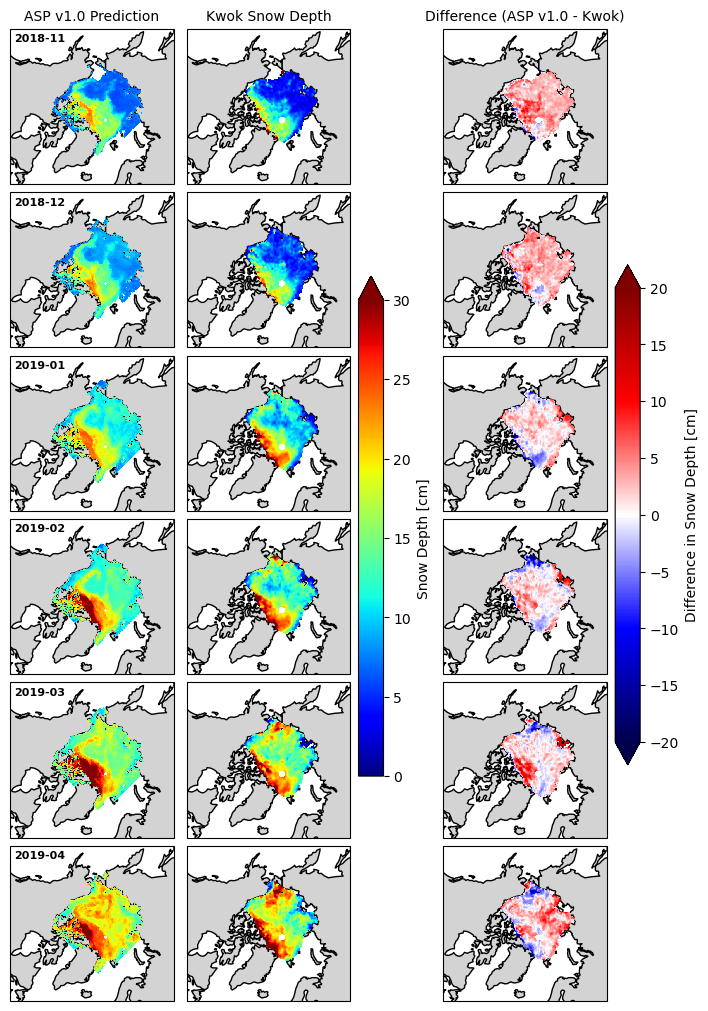

In [15]:
i = 0
fig, ax = plt.subplots(6, 3, figsize=(7, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()}, layout='constrained')
for kwok_file, asp_file in zip(kwok_files, ASP_files):
    ds_kwok = load_kwok_snowdepth(kwok_file)
    ds_asp = xr.open_dataset(asp_file)
    ds_asp = match_ASP_to_Kwok(ds_asp, ds_kwok)
    
    im_k = ax[i,0].pcolormesh(ds_asp.lon, ds_asp.lat, ds_asp.sd.isel(time=0)*100, cmap='jet', vmin=0, vmax=30, transform=ccrs.PlateCarree())
    ax[i,0].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax[i,0].set_extent([-4500000, 3200000, -3000000, 4300000], crs=ccrs.NorthPolarStereo())
    ax[i,0].text(-4300000, 3700000, ds_kwok.time.values[0].astype("M8[M]").astype(str), fontsize=8, transform=ccrs.NorthPolarStereo(), fontweight='bold')
    
    im = ax[i,1].pcolormesh(ds_kwok.lon, ds_kwok.lat, ds_kwok.sd.isel(time=0), cmap='jet', vmin=0, vmax=30, transform=ccrs.PlateCarree())
    ax[i,1].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax[i,1].set_extent([-4500000, 3200000, -3000000, 4300000], crs=ccrs.NorthPolarStereo())
    diff = ds_asp.sd.isel(time=0)*100 - ds_kwok.sd.isel(time=0)

    im_d = ax[i,2].pcolormesh(ds_asp.lon, ds_asp.lat, diff, cmap='seismic', vmin=-20, vmax=20, transform=ccrs.PlateCarree())
    ax[i,2].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax[i,2].set_extent([-4500000, 3200000, -3000000, 4300000], crs=ccrs.NorthPolarStereo())
    i += 1

cb = fig.colorbar(im_d, orientation='vertical', label='Difference in Snow Depth [cm]', ax=ax[:,2], extend='both')
cb.ax.tick_params(labelsize=10)
cb = fig.colorbar(im_k, orientation='vertical', label='Snow Depth [cm]', ax=ax[:,1], extend='max')
cb.ax.tick_params(labelsize=10)

ax[0,0].set_title('ASP v1.0 Prediction', fontsize=10)
ax[0,1].set_title('Kwok Snow Depth', fontsize=10)
ax[0,2].set_title('Difference (ASP v1.0 - Kwok)', fontsize=10)

fig.savefig(f'data/fig/ASP_vs_Kwok_snow_depth_comparison.png', dpi=300)

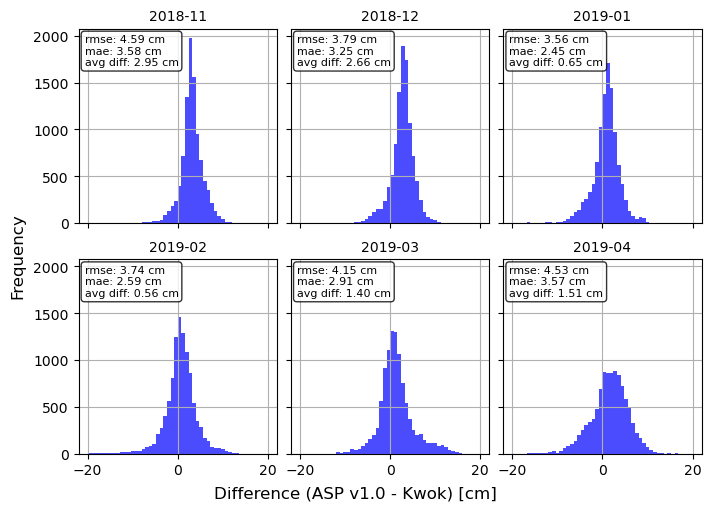

In [16]:


i = 0
fig, ax = plt.subplots(2, 3, figsize=(7, 5), layout='constrained', sharex=True, sharey=True)
ax = ax.ravel()
for kwok_file, asp_file in zip(kwok_files, ASP_files):
    ds_kwok = load_kwok_snowdepth(kwok_file)
    ds_asp = xr.open_dataset(asp_file)
    ds_asp = match_ASP_to_Kwok(ds_asp, ds_kwok)

    diff = ds_asp.sd.isel(time=0)*100 - ds_kwok.sd.isel(time=0)
    rmse = np.sqrt(np.nanmean(diff**2))
    mae = np.nanmean(np.abs(diff))
    avg_diff = np.nanmean(diff)
    histogram_data = diff.values.flatten()
    histogram_data = histogram_data[~np.isnan(histogram_data)]

    ax[i].hist(histogram_data, bins=50, color='blue', alpha=0.7, range=(-20, 20))
    ax[i].set_title(f'{ds_kwok.time.values[0].astype("M8[M]")}', fontsize=10)
    ax[i].grid()
    ax[i].text(0.03, 0.97, f'rmse: {rmse:.2f} cm\nmae: {mae:.2f} cm\navg diff: {avg_diff:.2f} cm', transform=ax[i].transAxes, fontsize=8,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    i += 1

fig.supxlabel('Difference (ASP v1.0 - Kwok) [cm]', fontsize=12)
fig.supylabel('Frequency', fontsize=12)
fig.savefig(f'data/fig/ASP_vs_Kwok_snow_depth_difference_histograms.pdf', dpi=300)

# Shi et al. (2024):

In [17]:
%cd C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer
import xesmf as xe
from cartopy import crs as ccrs
from cartopy import feature as cfeature


# Shi et al. (2024) predictions
def load_Shi_et_al_predictions(filename, gridfile =  "C:\\Users\\ehate\\Desktop\\ASP\\ASP_code_projects\\ASP_predictor\\data\\raw\\shi_et_al_2024_ESS\\NSIDC0771_LatLon_PS_N25km_v1.1.nc"):
    import numpy as np
    import xarray as xr
    data = np.fromfile(filename, dtype=np.float32).reshape(6,448,304)
    date = filename.split('_')[-1].split('.')[0]
    grid = xr.open_dataset(gridfile)
    grid['time'] = np.array([np.datetime64(f"{date[:4]}-{date[4:6]}-15")])
    grid['sd'] = (('time','y','x'), data[0,:,:].reshape(1,448,304))  # Assuming the first layer corresponds to snow depth   
    grid = grid.assign_coords(lat=(('y','x'), grid['latitude'].values))
    grid = grid.assign_coords(lon=(('y','x'), grid['longitude'].values))
    grid = grid.drop_vars(['latitude', 'longitude'])
    return grid

def match_ASP_to_Shi(ASP_ds, Shi_ds):
    # Coarsen ASP data to approximately match Kwok resolution
    ASP_ds = ASP_ds.coarsen(x=8, y=8, boundary='trim').mean()

    # Transform ASP coordinates from EPSG:6931 to EPSG:4326
    transformer = Transformer.from_crs("epsg:6931", "epsg:4326", always_xy=True)
    X, Y = np.meshgrid(ASP_ds.x.values, ASP_ds.y.values)
    lon, lat = transformer.transform(X, Y)
    ASP_ds = ASP_ds.assign_coords(lon=(("y", "x"), lon), lat=(("y", "x"), lat))    

    # Create regridder
    regridder = xe.Regridder(ASP_ds, Shi_ds, 'nearest_s2d', reuse_weights=False)
    
    # Regrid ASP data to Shi grid
    ASP_regridded = regridder(ASP_ds)
    return ASP_regridded


C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor


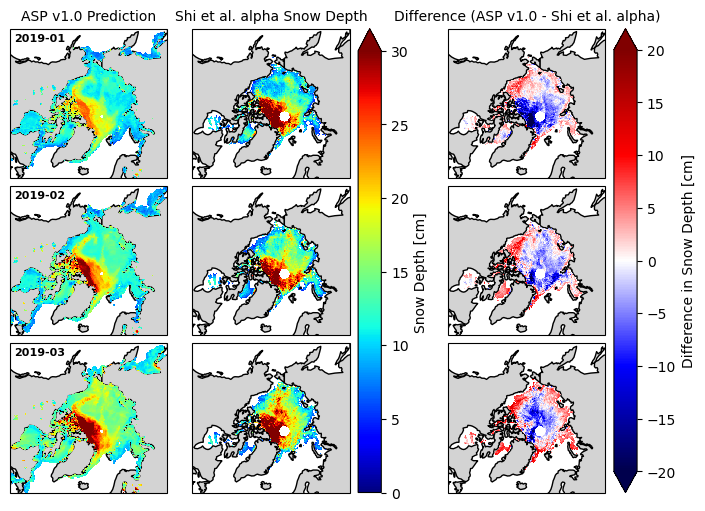

In [18]:
Shi_empirical_files = [
    #r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\raw\shi_et_al_2024_ESS\01_retrieval_results\alpha_Empirical_201811.bin",
    #r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\raw\shi_et_al_2024_ESS\01_retrieval_results\alpha_Empirical_201812.bin",
    r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\raw\shi_et_al_2024_ESS\01_retrieval_results\alpha_Empirical_201901.bin",
    r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\raw\shi_et_al_2024_ESS\01_retrieval_results\alpha_Empirical_201902.bin",
    r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\raw\shi_et_al_2024_ESS\01_retrieval_results\alpha_Empirical_201903.bin",
    #r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\raw\shi_et_al_2024_ESS\01_retrieval_results\alpha_Empirical_201904.bin",
]

ASP_files = [
    #r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\processed\predictions_monthly-mean\ASP_snow_depth_prediction_2018-11.nc",
    #r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\processed\predictions_monthly-mean\ASP_snow_depth_prediction_2018-12.nc",
    r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2019-01.nc",
    r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2019-02.nc",
    r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2019-03.nc",
    #r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2019-04.nc"
    ]

i = 0
fig, ax = plt.subplots(3, 3, figsize=(7, 5), subplot_kw={'projection': ccrs.NorthPolarStereo()}, layout='constrained')
for Shi_file, asp_file in zip(Shi_empirical_files, ASP_files):
    ds_Shi = load_Shi_et_al_predictions(Shi_file)
    ds_asp = xr.open_dataset(asp_file)
    ds_asp = match_ASP_to_Shi(ds_asp, ds_Shi)
    
    im_k = ax[i,0].pcolormesh(ds_asp.lon, ds_asp.lat, ds_asp.sd.isel(time=0)*100, cmap='jet', vmin=0, vmax=30, transform=ccrs.PlateCarree())
    ax[i,0].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax[i,0].set_extent([-4500000, 3200000, -3000000, 4300000], crs=ccrs.NorthPolarStereo())
    ax[i,0].text(-4300000, 3700000, ds_Shi.time.values[0].astype("M8[M]").astype(str), fontsize=8, transform=ccrs.NorthPolarStereo(), fontweight='bold')
    
    im = ax[i,1].pcolormesh(ds_Shi.lon, ds_Shi.lat, ds_Shi.sd.isel(time=0), cmap='jet', vmin=0, vmax=30, transform=ccrs.PlateCarree())
    ax[i,1].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax[i,1].set_extent([-4500000, 3200000, -3000000, 4300000], crs=ccrs.NorthPolarStereo())
    diff = ds_asp.sd.isel(time=0)*100 - ds_Shi.sd.isel(time=0)

    im_d = ax[i,2].pcolormesh(ds_asp.lon, ds_asp.lat, diff, cmap='seismic', vmin=-20, vmax=20, transform=ccrs.PlateCarree())
    ax[i,2].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax[i,2].set_extent([-4500000, 3200000, -3000000, 4300000], crs=ccrs.NorthPolarStereo())
    i += 1

cb = fig.colorbar(im_d, orientation='vertical', label='Difference in Snow Depth [cm]', ax=ax[:,2], extend='both')
cb.ax.tick_params(labelsize=10)
cb = fig.colorbar(im_k, orientation='vertical', label='Snow Depth [cm]', ax=ax[:,1], extend='max')
cb.ax.tick_params(labelsize=10)

ax[0,0].set_title('ASP v1.0 Prediction', fontsize=10)
ax[0,1].set_title('Shi et al. alpha Snow Depth', fontsize=10)
ax[0,2].set_title('Difference (ASP v1.0 - Shi et al. alpha)', fontsize=10)

fig.savefig(f'data/fig/ASP_vs_Shi_alpha_snow_depth_comparison.png', dpi=300)

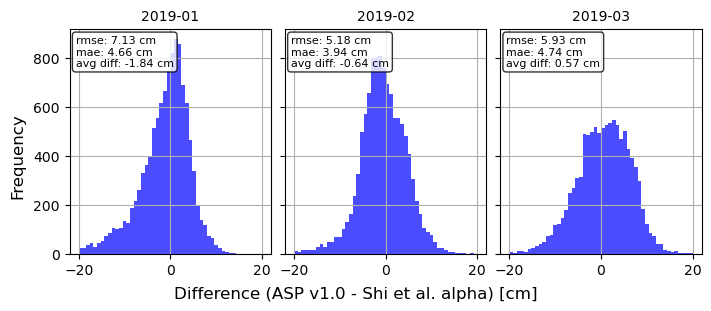

In [19]:
i = 0
fig, ax = plt.subplots(1, 3, figsize=(7, 3), layout='constrained', sharex=True, sharey=True)
ax = ax.ravel()
for Shi_file, asp_file in zip(Shi_empirical_files, ASP_files):
    ds_Shi = load_Shi_et_al_predictions(Shi_file)
    ds_asp = xr.open_dataset(asp_file)
    ds_asp = match_ASP_to_Shi(ds_asp, ds_Shi)

    diff = ds_asp.sd.isel(time=0)*100 - ds_Shi.sd.isel(time=0)
    rmse = np.sqrt(np.nanmean(diff**2))
    mae = np.nanmean(np.abs(diff))
    avg_diff = np.nanmean(diff)
    histogram_data = diff.values.flatten()
    histogram_data = histogram_data[~np.isnan(histogram_data)]

    ax[i].hist(histogram_data, bins=50, color='blue', alpha=0.7, range=(-20, 20))
    ax[i].set_title(f'{ds_Shi.time.values[0].astype("M8[M]")}', fontsize=10)
    ax[i].grid()
    ax[i].text(0.03, 0.97, f'rmse: {rmse:.2f} cm\nmae: {mae:.2f} cm\navg diff: {avg_diff:.2f} cm', transform=ax[i].transAxes, fontsize=8,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    i += 1

fig.supxlabel('Difference (ASP v1.0 - Shi et al. alpha) [cm]', fontsize=12)
fig.supylabel('Frequency', fontsize=12)
fig.savefig(f'data/fig/ASP_vs_Shii-alpha_snow_depth_difference_histograms.pdf', dpi=300)

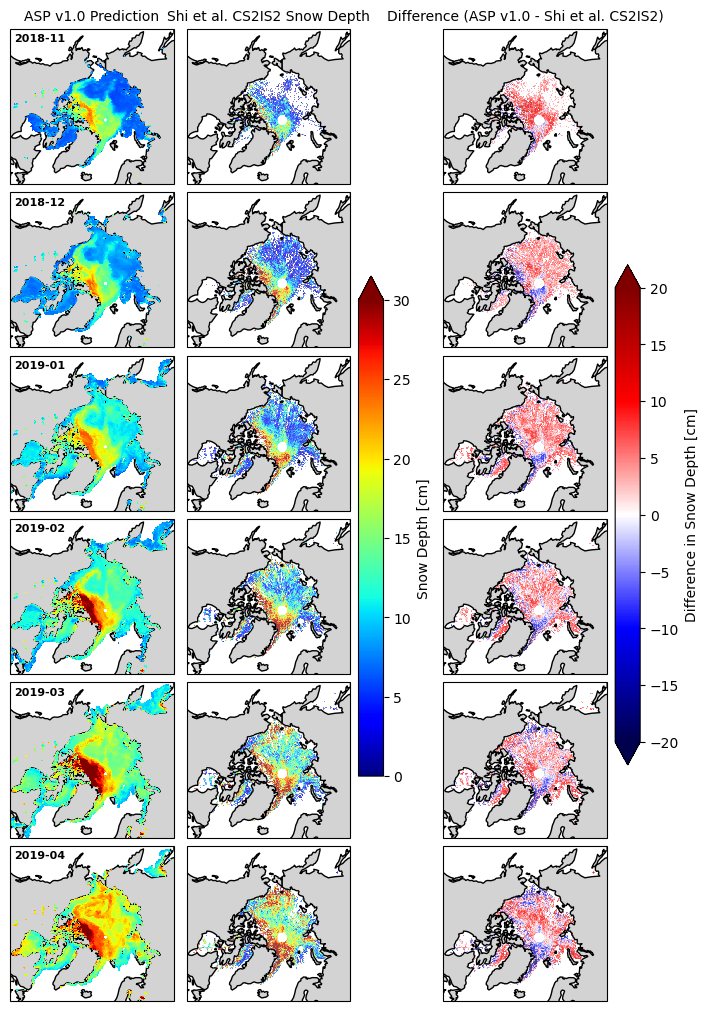

In [ ]:
Shi_empirical_files = [
    r".\data\raw\shi_et_al_2024_ESS\01_retrieval_results\CS2IS2_Empirical_201811.bin",
    r".\data\raw\shi_et_al_2024_ESS\01_retrieval_results\CS2IS2_Empirical_201812.bin",
    r".\data\raw\shi_et_al_2024_ESS\01_retrieval_results\CS2IS2_Empirical_201901.bin",
    r".\data\raw\shi_et_al_2024_ESS\01_retrieval_results\CS2IS2_Empirical_201902.bin",
    r".\data\raw\shi_et_al_2024_ESS\01_retrieval_results\CS2IS2_Empirical_201903.bin",
    r".\data\raw\shi_et_al_2024_ESS\01_retrieval_results\CS2IS2_Empirical_201904.bin",
]

ASP_files = [
    r".\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2018-11.nc",
    r".\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2018-12.nc",
    r".\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2019-01.nc",
    r".\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2019-02.nc",
    r".\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2019-03.nc",
    r".\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2019-04.nc"
    ]

i = 0
fig, ax = plt.subplots(6, 3, figsize=(7, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()}, layout='constrained')
for Shi_file, asp_file in zip(Shi_empirical_files, ASP_files):
    ds_Shi = load_Shi_et_al_predictions(Shi_file)
    ds_asp = xr.open_dataset(asp_file)
    ds_asp = match_ASP_to_Shi(ds_asp, ds_Shi)
    
    im_k = ax[i,0].pcolormesh(ds_asp.lon, ds_asp.lat, ds_asp.sd.isel(time=0)*100, cmap='jet', vmin=0, vmax=30, transform=ccrs.PlateCarree())
    ax[i,0].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax[i,0].set_extent([-4500000, 3200000, -3000000, 4300000], crs=ccrs.NorthPolarStereo())
    ax[i,0].text(-4300000, 3700000, ds_Shi.time.values[0].astype("M8[M]").astype(str), fontsize=8, transform=ccrs.NorthPolarStereo(), fontweight='bold')
    
    im = ax[i,1].pcolormesh(ds_Shi.lon, ds_Shi.lat, ds_Shi.sd.isel(time=0), cmap='jet', vmin=0, vmax=30, transform=ccrs.PlateCarree(), antialiased=True)
    ax[i,1].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax[i,1].set_extent([-4500000, 3200000, -3000000, 4300000], crs=ccrs.NorthPolarStereo())
    diff = ds_asp.sd.isel(time=0)*100 - ds_Shi.sd.isel(time=0)

    im_d = ax[i,2].pcolormesh(ds_asp.lon, ds_asp.lat, diff, cmap='seismic', vmin=-20, vmax=20, transform=ccrs.PlateCarree(), antialiased=True)
    ax[i,2].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax[i,2].set_extent([-4500000, 3200000, -3000000, 4300000], crs=ccrs.NorthPolarStereo())
    i += 1

cb = fig.colorbar(im_d, orientation='vertical', label='Difference in Snow Depth [cm]', ax=ax[:,2], extend='both')
cb.ax.tick_params(labelsize=10)
cb = fig.colorbar(im_k, orientation='vertical', label='Snow Depth [cm]', ax=ax[:,1], extend='max')
cb.ax.tick_params(labelsize=10)

ax[0,0].set_title('ASP v1.0 Prediction', fontsize=10)
ax[0,1].set_title('Shi et al. CS2IS2 Snow Depth', fontsize=10)
ax[0,2].set_title('Difference (ASP v1.0 - Shi et al. CS2IS2)', fontsize=10)

fig.savefig(f'data/fig/ASP_vs_Shi-CS2IS2_snow_depth_comparison.png', dpi=300)

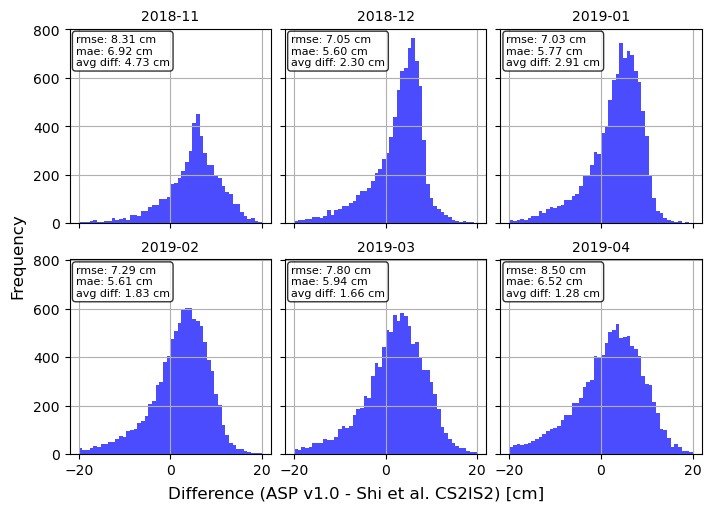

In [21]:
i = 0
fig, ax = plt.subplots(2, 3, figsize=(7, 5), layout='constrained', sharex=True, sharey=True)
ax = ax.ravel()
for Shi_file, asp_file in zip(Shi_empirical_files, ASP_files):
    ds_Shi = load_Shi_et_al_predictions(Shi_file)
    ds_asp = xr.open_dataset(asp_file)
    ds_asp = match_ASP_to_Shi(ds_asp, ds_Shi)

    diff = ds_asp.sd.isel(time=0)*100 - ds_Shi.sd.isel(time=0)
    rmse = np.sqrt(np.nanmean(diff**2))
    mae = np.nanmean(np.abs(diff))
    avg_diff = np.nanmean(diff)
    histogram_data = diff.values.flatten()
    histogram_data = histogram_data[~np.isnan(histogram_data)]

    ax[i].hist(histogram_data, bins=50, color='blue', alpha=0.7, range=(-20, 20))
    ax[i].set_title(f'{ds_Shi.time.values[0].astype("M8[M]")}', fontsize=10)
    ax[i].grid()
    ax[i].text(0.03, 0.97, f'rmse: {rmse:.2f} cm\nmae: {mae:.2f} cm\navg diff: {avg_diff:.2f} cm', transform=ax[i].transAxes, fontsize=8,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    i += 1

fig.supxlabel('Difference (ASP v1.0 - Shi et al. CS2IS2) [cm]', fontsize=12)
fig.supylabel('Frequency', fontsize=12)
fig.savefig(f'data/fig/ASP_vs_Shi-CS2IS2_snow_depth_difference_histograms.pdf', dpi=300)

# Shi vs. ASP vs. QL

In [ ]:
%cd C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from src.data_src.point_data_sources import OIB_QL
from src.utils.grid_utils import Grid
from pyproj import Transformer
import xesmf as xe

# Shi et al. (2024) predictions
def load_Shi_et_al_predictions(filename, gridfile =  ".\\data\\raw\\shi_et_al_2024_ESS\\NSIDC0771_LatLon_PS_N25km_v1.1.nc"):
    import numpy as np
    import xarray as xr
    data = np.fromfile(filename, dtype=np.float32).reshape(6,448,304)
    date = filename.split('_')[-1].split('.')[0]
    grid = xr.open_dataset(gridfile)
    grid['time'] = np.array([np.datetime64(f"{date[:4]}-{date[4:6]}-15")])
    grid['sd'] = (('time','y','x'), data[0,:,:].reshape(1,448,304))  # Assuming the first layer corresponds to snow depth   
    grid = grid.assign_coords(lat=(('y','x'), grid['latitude'].values))
    grid = grid.assign_coords(lon=(('y','x'), grid['longitude'].values))
    grid = grid.drop_vars(['latitude', 'longitude'])
    return grid

C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor


In [6]:
def match_ASP_to_Shi(ASP_ds, Shi_ds):
    # Coarsen ASP data to approximately match Kwok resolution
    ASP_ds = ASP_ds.coarsen(x=8, y=8, boundary='trim').mean()

    # Transform ASP coordinates from EPSG:6931 to EPSG:4326
    transformer = Transformer.from_crs("epsg:6931", "epsg:4326", always_xy=True)
    X, Y = np.meshgrid(ASP_ds.x.values, ASP_ds.y.values)
    lon, lat = transformer.transform(X, Y)
    ASP_ds = ASP_ds.assign_coords(lon=(("y", "x"), lon), lat=(("y", "x"), lat))    

    # Create regridder
    regridder = xe.Regridder(ASP_ds, Shi_ds, 'nearest_s2d', reuse_weights=False)
    
    # Regrid ASP data to Shi grid
    ASP_regridded = regridder(ASP_ds)
    return ASP_regridded

def obs_pred_plot(ax, y_true, y_pred, weights = None, val_range=(0,50),**kwargs):
    scatter = ax.scatter(y_true, y_pred, c=weights, label='Observations',**kwargs)
    ax.plot([val_range[0], val_range[1]], [val_range[0], val_range[1]], 'r--', label='best fit')
    ax.set_xlim(val_range)
    ax.set_ylim(val_range)

def sample_data_to_QL_df(gridded_QL_df, ds, id_var='sampled_sd'):
    sampled_df = gridded_QL_df.copy()
    sampled_values = []
    for _, row in gridded_QL_df.iterrows():
        lat = row['lat']
        lon = row['lon']
        # Find nearest grid point
        abs_lat_diff = np.abs(ds.lat - lat)
        abs_lon_diff = np.abs(ds.lon - lon)
        total_diff = abs_lat_diff + abs_lon_diff
        y_idx, x_idx = np.unravel_index(np.nanargmin(total_diff.values), total_diff.shape)
        sampled_value = ds.sd.isel(y=y_idx, x=x_idx).values[0]
        sampled_values.append(sampled_value)    
    sampled_df[id_var] = sampled_values
    return sampled_df

In [ ]:
Shi_alpha_file = r".\data\raw\shi_et_al_2024_ESS\01_retrieval_results\alpha_Empirical_201403.bin"
ASP_file      = r".\data\processed\predictions_v1.2_monthly-mean\ASP_snow_depth_prediction_2014-03.nc"
OIB_file      = r".\data\processed\OIB_predictions_monthly-mean\OIB_snow_depth_prediction_2014-03.nc"

ASP_ds = xr.open_dataset(ASP_file).coarsen(x=8, y=8, boundary='trim').mean()
transformer = Transformer.from_crs("epsg:6931", "epsg:4326", always_xy=True)
X, Y = np.meshgrid(ASP_ds.x.values, ASP_ds.y.values)
lon, lat = transformer.transform(X, Y)
ASP_ds = ASP_ds.assign_coords(lon=(("y", "x"), lon), lat=(("y", "x"), lat))
ASP_ds['sd'] = ASP_ds['sd'] * 100  # Convert to cm

OIB_ds = xr.open_dataset(OIB_file).coarsen(x=8, y=8, boundary='trim').mean()
OIB_ds = OIB_ds.assign_coords(lon=(("y", "x"), lon), lat=(("y", "x"), lat))
OIB_ds['sd'] = OIB_ds['sd'] * 100  # Convert to cm
Shi_alpha_ds = load_Shi_et_al_predictions(Shi_alpha_file)

OIB_QL_dir = r'data\raw\IceBridge_Sea_Ice_Freeboard_SnowDepth_and_Thickness_QuickLook\2014_GR_NASA'
OIB_QL_obj = OIB_QL(OIB_QL_dir)
gridded_OIB_QL = OIB_QL_obj.resample_bucket(Grid.from_predefined('EASE2_N25km')).data
gridded_OIB_QL = gridded_OIB_QL[gridded_OIB_QL.time.dt.month == 3]

gridded_OIB_QL = sample_data_to_QL_df(gridded_OIB_QL, ASP_ds, id_var="ASP_sampled_sd")
gridded_OIB_QL = sample_data_to_QL_df(gridded_OIB_QL, OIB_ds, id_var="OIB_sampled_sd")
gridded_OIB_QL = sample_data_to_QL_df(gridded_OIB_QL, Shi_alpha_ds, id_var="Shi_alpha_sampled_sd")
gridded_OIB_QL['SD_mean']*=100

Processing dates: 100%|██████████| 15/15 [00:02<00:00,  5.84date/s]


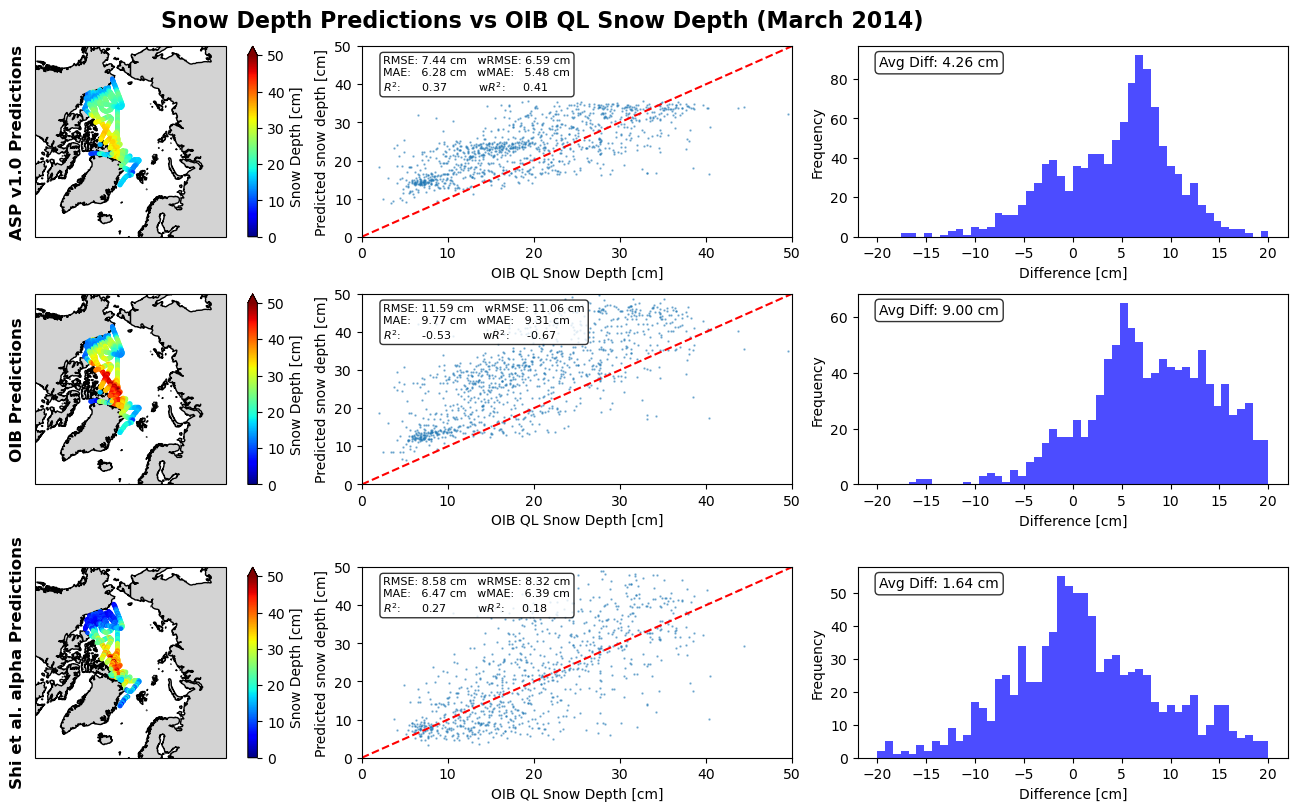

In [8]:
fig = plt.figure(figsize=(15,8),layout='constrained')

#ig, ax = plt.subplots(3, 3, figsize=(12, 12), layout='constrained', sharex='col', sharey='row', subplot_kw={'projection': ccrs.NorthPolarStereo()})
variables = ['ASP_sampled_sd', 'OIB_sampled_sd', 'Shi_alpha_sampled_sd']
titles = ['ASP v1.0 Predictions', 'OIB Predictions', 'Shi et al. alpha Predictions']

# Column 1: Maps
for i, var in enumerate(variables):

    ax = plt.subplot(3, 3, i*3 + 1, projection=ccrs.NorthPolarStereo())
    sc = ax.scatter(gridded_OIB_QL['lon'], gridded_OIB_QL['lat'], c=gridded_OIB_QL[var], cmap='jet', vmin=0, vmax=50, s=5, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
    cb = fig.colorbar(sc, ax=ax, orientation='vertical', label='Snow Depth [cm]', extend='max')
    cb.ax.tick_params(labelsize=10)
    ax.text(-0.05, 0.5, titles[i],
            va='center', ha='right',
            rotation='vertical',
            transform=ax.transAxes,  # <--- use Axes coordinates
            fontsize=12,
            fontweight='bold')

# Column 2: Scatter plots vs OIB QL
for i, var in enumerate(variables):
        ax = plt.subplot(3, 3, i*3 + 2)
        obs_pred_plot(ax, gridded_OIB_QL['SD_mean'], gridded_OIB_QL[var],val_range=(0,50), s=0.5,alpha=0.5)
        ax.set_xlim(0,50)
        ax.set_ylim(0,50)
        ax.set_xlabel('OIB QL Snow Depth [cm]')
        ax.set_ylabel(f'Predicted snow depth [cm]')
        # Calculate statistics
        y_true = gridded_OIB_QL['SD_mean']
        y_pred = gridded_OIB_QL[var]
        df = gridded_OIB_QL
        diff = gridded_OIB_QL[var] - gridded_OIB_QL['SD_mean']
        rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
        wrmse = np.sqrt(np.mean(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples']))))
        mae = np.mean(np.abs(y_true - y_pred))
        wmae = np.mean(np.abs(y_true - y_pred) * (df['num_samples'] / np.mean(df['num_samples'])))
        r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
        wr2 = 1 - (np.sum(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ) / np.sum( ((y_true - np.mean(y_true)) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ))

        ax.text(0.05, 0.95, 
                f"RMSE: {rmse:.2f} cm   wRMSE: {wrmse:.2f} cm" + "\n" +
                f"MAE:   {mae:.2f} cm   wMAE:   {wmae:.2f} cm" + "\n" +
                f"$R^2$:      {r2:.2f}         w$R^2$:     {wr2:.2f}", 
                        transform=ax.transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Column 3: Histograms of differences
for i, var in enumerate(variables):
        ax = plt.subplot(3, 3, i*3 + 3)
        diff = gridded_OIB_QL[var] - gridded_OIB_QL['SD_mean']
        ax.hist(diff, bins=50, color='blue', alpha=0.7, range=(-20, 20))
        ax.set_xlabel('Difference [cm]')
        ax.set_ylabel('Frequency')
        # Calculate statistics
        rmse = np.sqrt(np.nanmean(diff**2))
        mae = np.nanmean(np.abs(diff))
        avg_diff = np.nanmean(diff)
        ax.text(0.05, 0.95, f'Avg Diff: {avg_diff:.2f} cm', transform=ax.transAxes, fontsize=10,
                     verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
fig.suptitle('Snow Depth Predictions vs OIB QL Snow Depth (March 2014)', fontsize=16, fontweight='bold')
fig.savefig(f'data/fig/ASP_OIB_Shi_alpha_vs_OIB_QL_Mar2014_comparison.png', dpi=300, bbox_inches='tight')

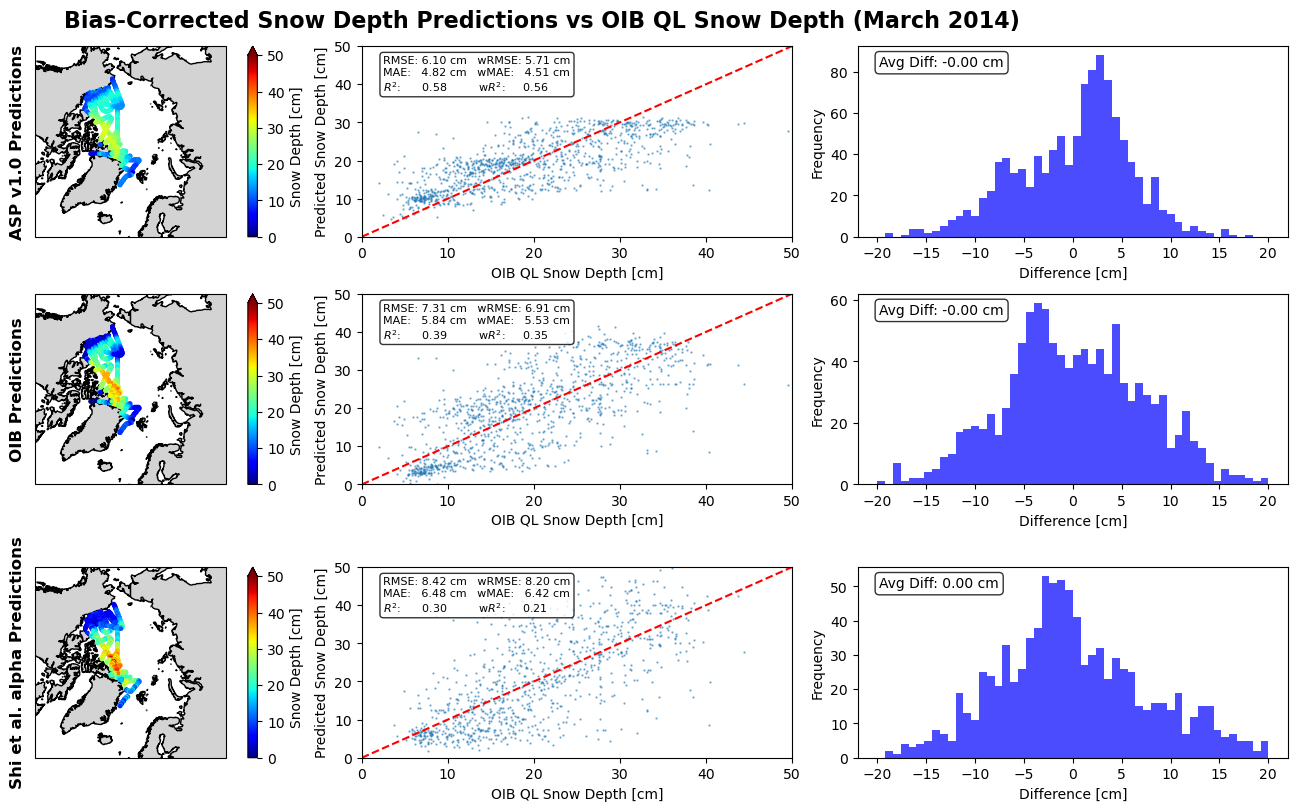

In [9]:
# Bias correction
gridded_OIB_QL['ASP_sampled_sd_bc'] = gridded_OIB_QL['ASP_sampled_sd'] - np.nanmean(gridded_OIB_QL['ASP_sampled_sd'] - gridded_OIB_QL['SD_mean'])
gridded_OIB_QL['OIB_sampled_sd_bc'] = gridded_OIB_QL['OIB_sampled_sd'] - np.nanmean(gridded_OIB_QL['OIB_sampled_sd'] - gridded_OIB_QL['SD_mean'])
gridded_OIB_QL['Shi_alpha_sampled_sd_bc'] = gridded_OIB_QL['Shi_alpha_sampled_sd'] - np.nanmean(gridded_OIB_QL['Shi_alpha_sampled_sd'] - gridded_OIB_QL['SD_mean'])


fig = plt.figure(figsize=(15,8),layout='constrained')

#ig, ax = plt.subplots(3, 3, figsize=(12, 12), layout='constrained', sharex='col', sharey='row', subplot_kw={'projection': ccrs.NorthPolarStereo()})
variables = ['ASP_sampled_sd_bc', 'OIB_sampled_sd_bc', 'Shi_alpha_sampled_sd_bc']
titles = ['ASP v1.0 Predictions', 'OIB Predictions', 'Shi et al. alpha Predictions']

# Column 1: Maps
for i, var in enumerate(variables):

    ax = plt.subplot(3, 3, i*3 + 1, projection=ccrs.NorthPolarStereo())
    sc = ax.scatter(gridded_OIB_QL['lon'], gridded_OIB_QL['lat'], c=gridded_OIB_QL[var], cmap='jet', vmin=0, vmax=50, s=5, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
    cb = fig.colorbar(sc, ax=ax, orientation='vertical', label='Snow Depth [cm]', extend='max')
    cb.ax.tick_params(labelsize=10)
    ax.text(-0.05, 0.5, titles[i],
        va='center', ha='right',
        rotation='vertical',
        transform=ax.transAxes,  # <--- use Axes coordinates
        fontsize=12,
        fontweight='bold')

# Column 2: Scatter plots vs OIB QL
for i, var in enumerate(variables):
        ax = plt.subplot(3, 3, i*3 + 2)
        obs_pred_plot(ax, gridded_OIB_QL['SD_mean'], gridded_OIB_QL[var],val_range=(0,50), s=0.5,alpha=0.5)
        ax.set_xlim(0,50)
        ax.set_ylim(0,50)
        ax.set_xlabel('OIB QL Snow Depth [cm]')
        ax.set_ylabel(f'Predicted Snow Depth [cm]')
        # Calculate statistics
        y_true = gridded_OIB_QL['SD_mean']
        y_pred = gridded_OIB_QL[var]
        df = gridded_OIB_QL
        diff = gridded_OIB_QL[var] - gridded_OIB_QL['SD_mean']
        rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
        wrmse = np.sqrt(np.mean(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples']))))
        mae = np.mean(np.abs(y_true - y_pred))
        wmae = np.mean(np.abs(y_true - y_pred) * (df['num_samples'] / np.mean(df['num_samples'])))
        r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
        wr2 = 1 - (np.sum(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ) / np.sum( ((y_true - np.mean(y_true)) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ))

        ax.text(0.05, 0.95, 
                f"RMSE: {rmse:.2f} cm   wRMSE: {wrmse:.2f} cm" + "\n" +
                f"MAE:   {mae:.2f} cm   wMAE:   {wmae:.2f} cm" + "\n" +
                f"$R^2$:      {r2:.2f}         w$R^2$:     {wr2:.2f}", 
                        transform=ax.transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Column 3: Histograms of differences
for i, var in enumerate(variables):
        ax = plt.subplot(3, 3, i*3 + 3)
        diff = gridded_OIB_QL[var] - gridded_OIB_QL['SD_mean']
        ax.hist(diff, bins=50, color='blue', alpha=0.7, range=(-20, 20))
        ax.set_xlabel('Difference [cm]')
        ax.set_ylabel('Frequency')
        # Calculate statistics
        rmse = np.sqrt(np.nanmean(diff**2))
        mae = np.nanmean(np.abs(diff))
        avg_diff = np.nanmean(diff)
        ax.text(0.05, 0.95, f'Avg Diff: {avg_diff:.2f} cm', transform=ax.transAxes, fontsize=10,
                     verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.suptitle('Bias-Corrected Snow Depth Predictions vs OIB QL Snow Depth (March 2014)', fontsize=16, fontweight='bold')
fig.savefig(f'data/fig/ASP_OIB_Shi_alpha_vs_OIB_QL_Mar2014_comparison_bias_corrected.png', dpi=300, bbox_inches='tight')

# PMW models

In [ ]:
%cd C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor
# imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.models import LinearRegression, KilicModel, MarkusAndCavalieriModel, RandomForestRegression
from src.data_src.gridded_data_sources import load_ERA5_data, load_CETB_data
from src.utils.grid_utils import Grid
from src.utils.data_utils import DataMapping
import pickle
import xarray as xr
import yaml
import os
from cartopy import crs as ccrs
from cartopy import feature as cfeature
import logging
from pyproj import Transformer
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

dates = [
    '2020-11-01',
    '2021-01-01',
    '2021-04-01'
]

input_features = ['6.9H', '6.9V', '10.7H', '10.7V', '18H', '18V', '23H', '23V', '36H', '36V', '89H', '89V', 'doy']
target_feature = 'SD_mean'  
weight_feature = 'weights'

ASP_dir = r'C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\processed\predictions'
ASP_file_format = 'ASP_snow_depth_predictions_{}.nc'

logging.info('Defining models...')
OIB_model = r'C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\processed\models\OIB\ASP_RFR-model_OIB_N3.125km.pkl'
OIB_model = RandomForestRegression.load(OIB_model)

# defining models
models = {
    'Linear Regression': LinearRegression(input_features=input_features, target_feature=target_feature, weight_feature=weight_feature),
    'OIB': OIB_model,
    'Markus and Cavalieri': MarkusAndCavalieriModel(target_feature=target_feature),     
    'Kilic': KilicModel(target_feature=target_feature),
}

logging.info('Fitting Linear Regression model...')
train_df = pd.read_parquet('data/intermediate/datasets/EASE2_LARM-smoothed_N3.125km_v1.1/ASP_train.parquet')
train_df = train_df[train_df['primary_id'].isin(['C2I'])]
train_df.dropna(inplace=True)
models['Linear Regression'].fit(train_df)


transformer = Transformer.from_crs("epsg:6931", "epsg:4326", always_xy=True)

config = yaml.safe_load(open(r'.\configs\pipeline_configs\predict_data.yaml'))
cetb_channels = config['CETB']['channels']
era5_channels = config['ERA5']['channels']

# loading and modifying target grid
target_grid = Grid.from_predefined(config['grid'])
target_grid.modify_extent(config['output_extent'])

logging.info('Loading data mappings...')
cetb_mapping = DataMapping(config['CETB']['directory'], 'CETB')
era5_mapping = DataMapping(config['ERA5']['directory'], 'ERA5')

output_dict = {}
for date_idx, date_str in enumerate(dates):
    logging.info(f'Processing date: {date_str}')
    output_dict[date_str] = {}

    ASP_ds = xr.open_dataset(os.path.join(ASP_dir, ASP_file_format.format(date_str)), engine='netcdf4')
    output_dict[date_str]['ASP v1.0'] = ASP_ds['sd'].isel(time=0).values
    date = pd.Timestamp(date_str)
    # Identify available data for given date
    cetb_data = cetb_mapping.get_by_date(date)
    era5_data = era5_mapping.get_by_date(date)

    # loading data
    cetb_data = cetb_data[cetb_data['channel'].isin(cetb_channels)]
    cetb_scene = load_CETB_data(cetb_data['filename'], grid=target_grid)        
    era5_data = era5_data[era5_data['channel'].isin(era5_channels)]
    era5_scene = load_ERA5_data(era5_data['filename'], grid=target_grid)
    # merging data
    scene = cetb_scene + era5_scene

    # masking
    mask = (scene.data[config['mask']['channel']] > config['mask']['threshold']) 
    
    for model_idx, (model_name, model) in enumerate(models.items()):
        logging.info(f'Predicting with model: {model_name}')

        sd_pred = model.predict(scene, mask=mask)
        sd_pred = (sd_pred.data['SD_mean'].isel(time=0)*100).values
        output_dict[date_str][model_name] = sd_pred
        

C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor
2025-11-24 13:53:35,782 | INFO : Defining models...
2025-11-24 13:53:35,802 | INFO : Fitting Linear Regression model...
2025-11-24 13:53:36,831 | INFO : Loading data mappings...
2025-11-24 13:54:28,474 | INFO : Processing date: 2020-11-01
2025-11-24 13:54:35,270 | INFO : Predicting with model: Linear Regression
2025-11-24 13:55:13,596 | INFO : Predicting with model: OIB
2025-11-24 13:55:48,476 | INFO : Predicting with model: Markus and Cavalieri
2025-11-24 13:56:20,390 | INFO : Predicting with model: Kilic
2025-11-24 13:56:48,231 | INFO : Processing date: 2021-01-01
2025-11-24 13:56:52,959 | INFO : Predicting with model: Linear Regression
2025-11-24 13:57:25,316 | INFO : Predicting with model: OIB
2025-11-24 13:58:05,300 | INFO : Predicting with model: Markus and Cavalieri
2025-11-24 13:58:22,700 | INFO : Predicting with model: Kilic
2025-11-24 13:58:37,327 | INFO : Processing date: 2021-04-01
2025-11-24 13:58:41,229 | INFO : P

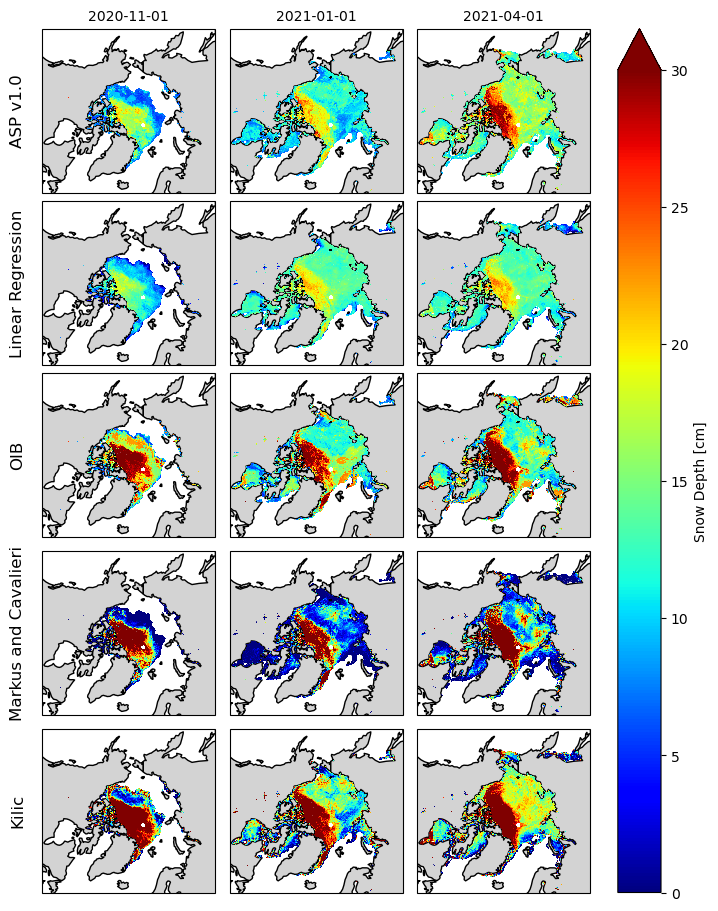

In [28]:
fig, ax = plt.subplots(5, 3, figsize=(7, 9), layout='constrained', subplot_kw={'projection': ccrs.NorthPolarStereo()})

# extract from output_dict and plot as needed
for date_idx, date_str in enumerate(dates):

    ASP_ds = xr.open_dataset(os.path.join(ASP_dir, ASP_file_format.format(date_str)), engine='netcdf4')
    X, Y = np.meshgrid(ASP_ds.x.values, ASP_ds.y.values)
    lon, lat = transformer.transform(X, Y)

    for model_idx, model_name in enumerate(list(output_dict[date_str].keys())):
        model_ax = ax[model_idx, date_idx]
        sd_data = output_dict[date_str][model_name]
        if model_name == 'ASP v1.0':
            sd_data = sd_data * 100  # convert to cm
        im = model_ax.pcolormesh(lon[::4,::4], lat[::4,::4], sd_data[::4,::4], cmap='jet', vmin=0, vmax=30, transform=ccrs.PlateCarree(), antialiased=True)
        
        model_ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
        model_ax.set_extent([-4500000, 3200000, -3000000, 4300000], crs=ccrs.NorthPolarStereo())

        if model_idx == 0:
            model_ax.set_title(f'{date_str}', fontsize=10)

        if date_idx == 0:
            model_ax.text(-0.1, 0.5, model_name,
            va='center', ha='right',
            rotation='vertical',
            transform=model_ax.transAxes,  # <--- use Axes coordinates
            fontsize=12)


cb = fig.colorbar(im, orientation='vertical', label='Snow Depth [cm]', ax=ax[:, :], extend='max')
cb.ax.tick_params(labelsize=10)

fig.savefig(f'data/fig/ASP_and_model_snow_depth_predictions_comparison.png', dpi=300, bbox_inches='tight')

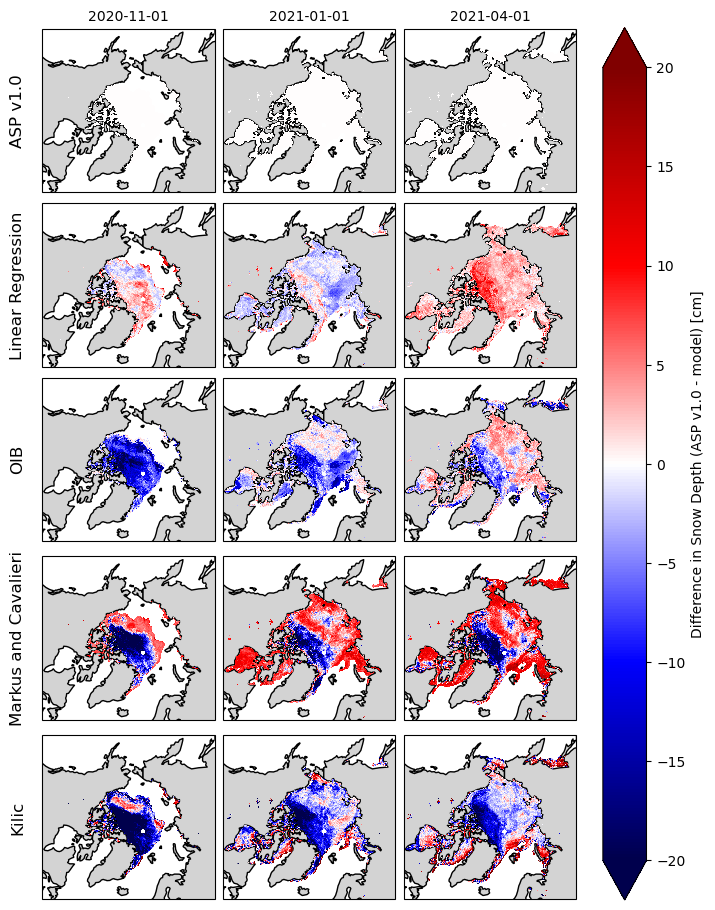

In [29]:
# making figure again, but where differences to ASP are shown

fig, ax = plt.subplots(5, 3, figsize=(7, 9), layout='constrained', subplot_kw={'projection': ccrs.NorthPolarStereo()})

# extract from output_dict and plot as needed
for date_idx, date_str in enumerate(dates):

    ASP_ds = xr.open_dataset(os.path.join(ASP_dir, ASP_file_format.format(date_str)), engine='netcdf4')
    X, Y = np.meshgrid(ASP_ds.x.values, ASP_ds.y.values)
    lon, lat = transformer.transform(X, Y)

    for model_idx, model_name in enumerate(list(output_dict[date_str].keys())):
        model_ax = ax[model_idx, date_idx]
        
        if model_name == 'ASP v1.0':
            sd_data = output_dict[date_str][model_name] * 100  # convert to cm
        else:
            sd_data = output_dict[date_str][model_name]
        diff = output_dict[date_str]['ASP v1.0'] * 100 - sd_data
        im = model_ax.pcolormesh(lon[::4,::4], lat[::4,::4], diff[::4,::4], cmap='seismic', vmin=-20, vmax=20, transform=ccrs.PlateCarree(), antialiased=True)
        
        model_ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
        model_ax.set_extent([-4500000, 3200000, -3000000, 4300000], crs=ccrs.NorthPolarStereo())

        if model_idx == 0:
            model_ax.set_title(f'{date_str}', fontsize=10)

        if date_idx == 0:
            model_ax.text(-0.1, 0.5, model_name,
            va='center', ha='right',
            rotation='vertical',
            transform=model_ax.transAxes,  # <--- use Axes coordinates
            fontsize=12)


cb = fig.colorbar(im, orientation='vertical', label='Difference in Snow Depth (ASP v1.0 - model) [cm]', ax=ax[:, :], extend='both')
cb.ax.tick_params(labelsize=10)

fig.savefig(f'data/fig/ASP_and_model_snow_depth_predictions_difference_comparison.png', dpi=300, bbox_inches='tight')

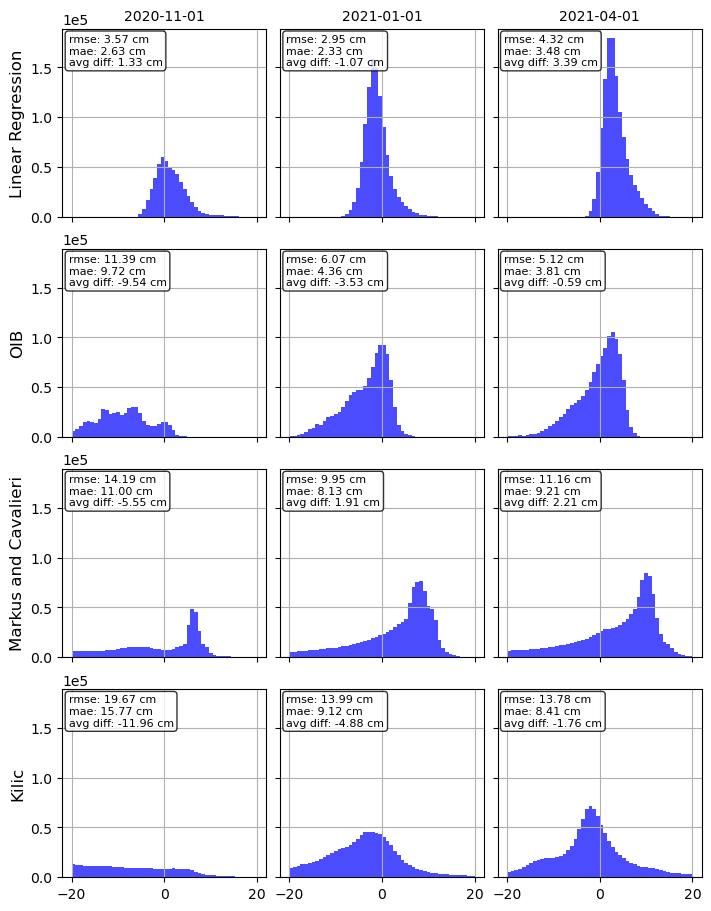

In [ ]:
# Like for kwok comparison, make histogram of differences for all dates and models

fig, ax = plt.subplots(4, 3, figsize=(7, 9), layout='constrained', sharex=True, sharey=True)

for date_idx, date_str in enumerate(dates):
    for model_idx, model_name in enumerate(list(output_dict[date_str].keys())):
        model_ax = ax[model_idx-1, date_idx]
        
        if model_name == 'ASP v1.0':
            continue  # skip ASP itself
        sd_data = output_dict[date_str][model_name]
        diff = output_dict[date_str]['ASP v1.0'] * 100 - sd_data
        histogram_data = diff.flatten()
        histogram_data = histogram_data[~np.isnan(histogram_data)]

        model_ax.hist(histogram_data, bins=50, color='blue', alpha=0.7, range=(-20, 20))
        model_ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        model_ax.grid()

        rmse = np.sqrt(np.nanmean(diff**2))
        mae = np.nanmean(np.abs(diff))
        avg_diff = np.nanmean(diff)


        model_ax.text(0.03, 0.97, f'rmse: {rmse:.2f} cm\nmae: {mae:.2f} cm\navg diff: {avg_diff:.2f} cm', transform=model_ax.transAxes, fontsize=8,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


        if model_idx == 1:
            model_ax.set_title(f'{date_str}', fontsize=10)

        if date_idx == 0:
            model_ax.set_ylabel(model_name, fontsize=12)

fig.savefig(f'data/fig/ASP_vs_model_snow_depth_difference_histograms.pdf', dpi=300)